In [47]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import glob
import matplotlib.pyplot as plt
sns.set_context("talk")
from Bio import SeqIO
import warnings
warnings.filterwarnings("ignore")


def get_hits_summary(hits_path, label = "label_placeholder", drop = None):
    # Check how many structures I retrieve
    colnames  = "query,target,fident,alnlen,gapopen,qseq,tseq,qstart,qend,tstart,tend,evalue,bits,qcov,tcov,qcut,tcut,qcut_len,tcut_len,qseq_len,tseq_len,family".split(",")
    hits_summary = pd.DataFrame()
    for file in glob.glob(hits_path):
        family = os.path.splitext(os.path.basename(file))[0]
        
        if os.path.getsize(file) > 0: 
            df = pd.read_csv(file, sep= "\t", header = None)
            if drop: 
                df.drop(df.columns[14:19], axis=1, inplace=True)
            df["family"] = family.replace("_filtered_hits", "")
            hits_summary = pd.concat([hits_summary, df])
    hits_summary = hits_summary.set_axis(colnames, axis='columns')
    hits_summary = hits_summary[["family", "query"]].drop_duplicates().groupby("family").count().reset_index().set_axis(["family", "found"], axis='columns')
    hits_summary["label"] = label
    return(hits_summary)

def prep_hits_for_plot(db_filter, label, families, outdir ):
    hits_1 = get_hits_summary(os.path.join(outdir, "SEARCH/filter/"+db_filter+"/*.m8"),   label = label)
    hits_1_summary = hits_1.merge(families, on = "family", how = "outer").fillna(0)
    hits_1_summary["missing"] = hits_1_summary.n_sequences- hits_1_summary.found
    hits_1_summary['found_proportion'] = hits_1_summary['found'] / (hits_1_summary['found'] + hits_1_summary['missing'])
    hits_1_summary['missing_proportion'] = hits_1_summary['missing'] / (hits_1_summary['found'] + hits_1_summary['missing'])
    return(hits_1_summary)

# Structures AF2 
def get_seq(PDBFile):
    with open(PDBFile, 'r') as pdb_file:
        for record in SeqIO.parse(pdb_file, 'pdb-atom'):
            return(str(record.seq))

def get_structure_df(structure_path):
    df = pd.DataFrame(columns=["id", "seq", "family"])
    for structure in structure_path:
        seq = get_seq(structure)
        name = structure.split("/")[-1].split(".")[0]
        # add to dataframe
        df.loc[len(df)] = {"id": name, "seq": seq, "family": structure.split("/")[-2]}
    return(df)

# Real sequence
def get_real_sequence(path_fasta):
    df_references = pd.DataFrame(columns=["id", "seq", "family"])
    for reference in path_fasta:
        # save the sequence and id in dataframe
        for record in SeqIO.parse(reference, "fasta"):
            df_references.loc[len(df_references)] = {"id": record.id, "seq": str(record.seq), "family": reference.split("/")[-1].split(".")[0] }
    return(df_references)

def calculate_percentage_identity(seq1, seq2):
    # if seq1 or seq2 are nan, return 0
    if pd.isna(seq1) or pd.isna(seq2):
        percentage_identity = 0
        return percentage_identity
    if len(seq1) != len(seq2):
        percentage_identity = 0

    identical_count = sum(1 for a, b in zip(seq1, seq2) if a == b)

    percentage_identity = (identical_count / len(seq1)) * 100
    return percentage_identity

# Collect dataset infos

In [19]:
outdir = "../outdir/REFERENCES"
families = pd.read_csv(os.path.join(outdir, "SUMMARIES/input_sequences/stats_summary_report.csv"))
families.rename(columns = {"id":"family"}, inplace=True)
families.family = families.family.str.replace('.', "-", regex = False)

In [20]:
hits_1_summary = prep_hits_for_plot("0.99_1", label = "1", families = families, outdir = outdir)
hits_9_summary = prep_hits_for_plot("0.9_1", label = "9", families = families, outdir = outdir)

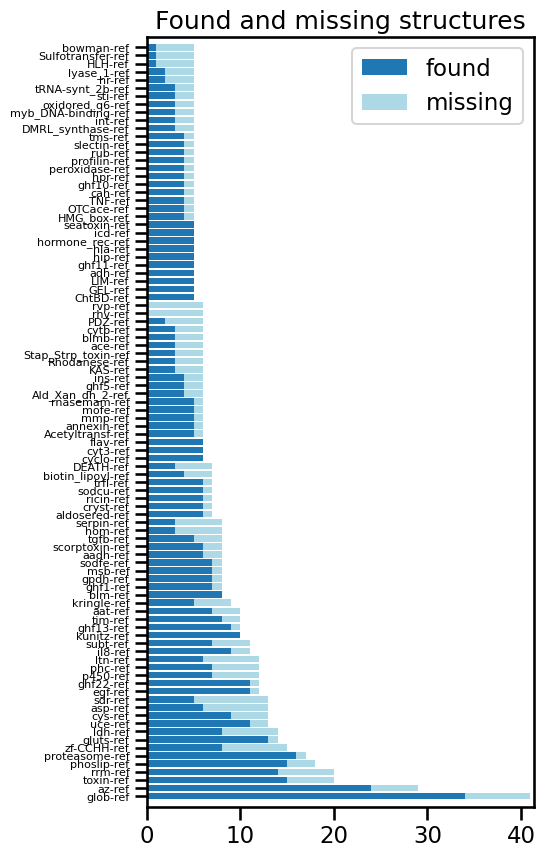

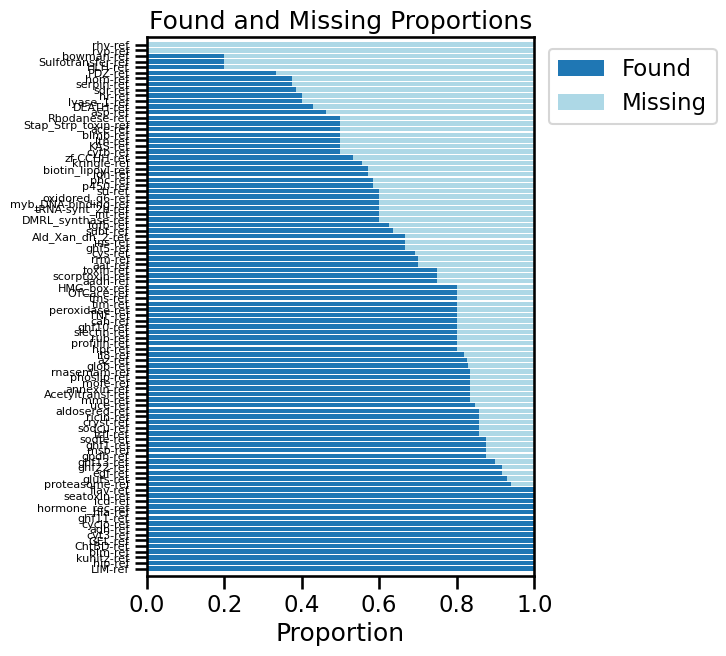

In [49]:
hits = hits_1_summary
hits = hits.sort_values(by=['n_sequences', "found"], ascending=False)
plt.figure(figsize=(5, 10))
plt.rc('ytick', labelsize=8)
plt.barh(hits.family, hits.found, label = "found")
plt.barh(hits.family, hits["missing"], left= hits.found, label = "missing", color = "lightblue")
plt.title("Found and missing structures")
plt.legend(loc = "upper right")
plt.margins(0.01)
plt.show()

# Sort by the found_proportion in descending order
hits = hits.sort_values(by=['found_proportion'], ascending=False)
plt.figure(figsize=(5, 7))
# make labels smalle 
plt.rc('ytick', labelsize=8)
# Plot found proportions
plt.barh(hits.family, hits['found_proportion'], label="Found")
# Plot missing proportions next to found proportions
plt.barh(hits.family, hits['missing_proportion'], left=hits['found_proportion'], label="Missing", color="lightblue")
plt.title("Found and Missing Proportions" ) 
plt.xlabel("Proportion")
plt.legend(loc="upper right", bbox_to_anchor=(1.5, 1))
plt.margins(0.01)
plt.show()

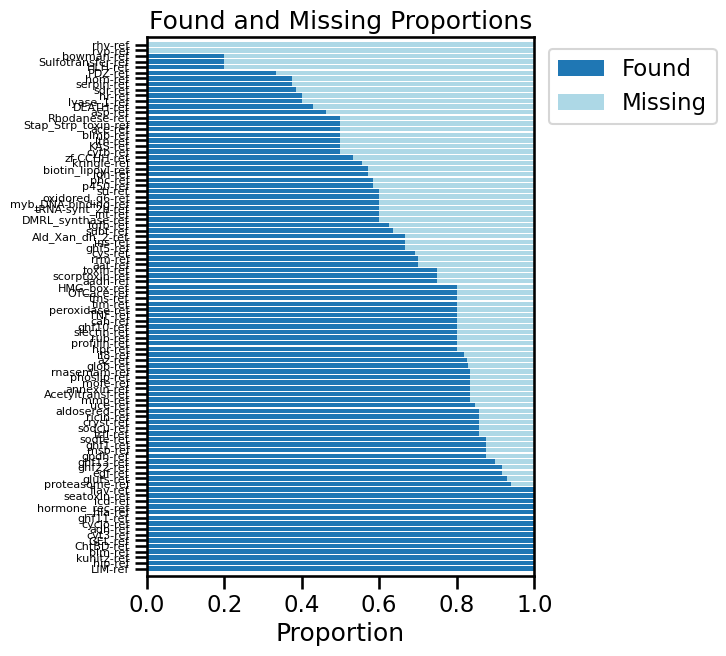

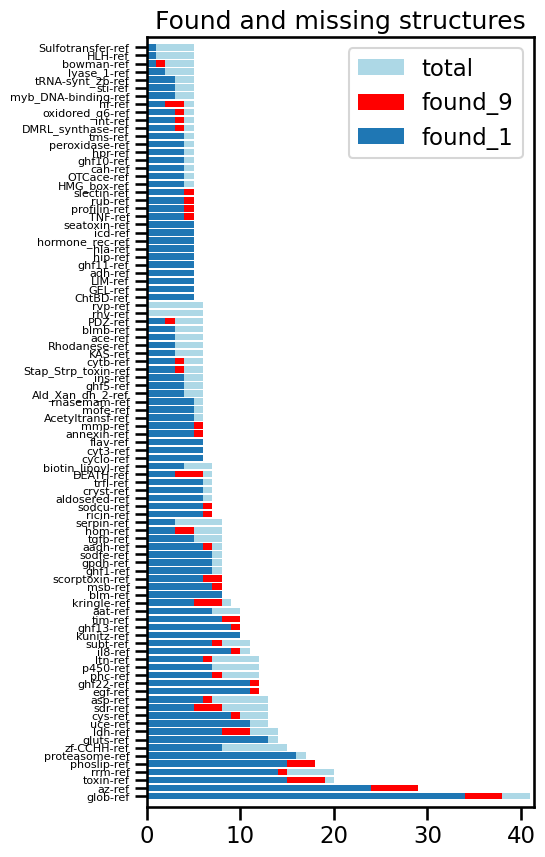

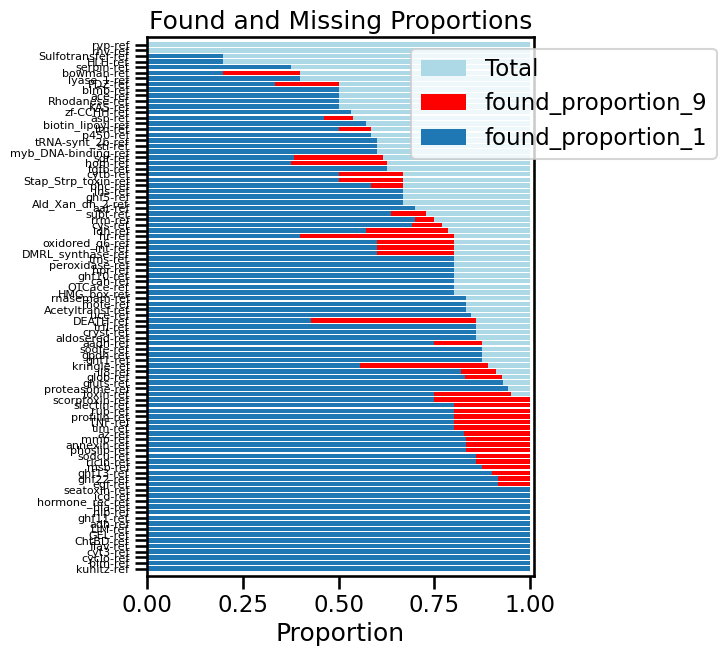

In [48]:
# Combined 
hits = hits_1_summary.merge(hits_9_summary, on = ["family", "n_sequences"], how = "outer", suffixes= ("_1", "_9")).drop(columns = ["label_1", "label_9"]).fillna(0)
hits = hits.sort_values(by=['n_sequences', "found_9", "found_1"], ascending=False)
plt.figure(figsize=(5, 10))
plt.rc('ytick', labelsize=8)
plt.barh(hits.family, hits.n_sequences, label = "total", color = "lightblue")
plt.barh(hits.family, hits.found_9, label = "found_9", color = "red")
plt.barh(hits.family, hits.found_1, label = "found_1")
plt.title("Found and missing structures")
plt.legend(loc = "upper right")
plt.margins(0.01)
plt.show()

# Sort by the found_proportion in descending order
hits = hits.sort_values(by=['found_proportion_9', "found_proportion_1"], ascending=False)
hits["total"] = 1
plt.figure(figsize=(5, 7))
# make labels smalle 
plt.rc('ytick', labelsize=8)
# Plot found proportions
plt.barh(hits.family, hits['total'], label="Total", color = "lightblue")
# Plot missing proportions next to found proportions
plt.barh(hits.family, hits.found_proportion_9, label="found_proportion_9", color="red")
plt.barh(hits.family, hits.found_proportion_1, label="found_proportion_1")

plt.title("Found and Missing Proportions" ) 
plt.xlabel("Proportion")
plt.legend(loc="upper right", bbox_to_anchor=(1.5, 1))
plt.margins(0.01)
plt.show()

In [41]:
hits_missing = hits[hits.missing > 0]
",".join(hits_missing.family.tolist())


'toxin-ref,proteasome-ref,gluts-ref,glob-ref,il8-ref,kringle-ref,sodfe-ref,gpdh-ref,ghf1-ref,aadh-ref,DEATH-ref,aldosered-ref,cryst-ref,trfl-ref,uce-ref,rnasemam-ref,mofe-ref,Acetyltransf-ref,OTCace-ref,tms-ref,cah-ref,ghf10-ref,hr-ref,int-ref,peroxidase-ref,oxidored_q6-ref,DMRL_synthase-ref,HMG_box-ref,hpr-ref,ldh-ref,cys-ref,rrm-ref,subt-ref,aat-ref,Ald_Xan_dh_2-ref,ins-ref,ghf5-ref,cytb-ref,Stap_Strp_toxin-ref,phc-ref,hom-ref,tgfb-ref,sdr-ref,myb_DNA-binding-ref,sti-ref,tRNA-synt_2b-ref,ltn-ref,p450-ref,biotin_lipoyl-ref,asp-ref,zf-CCHH-ref,blmb-ref,ace-ref,Rhodanese-ref,PDZ-ref,KAS-ref,bowman-ref,lyase_1-ref,serpin-ref,HLH-ref,Sulfotransfer-ref,rvp-ref,rhv-ref'

In [40]:
hits_found = hits[hits.missing == 0]
len(hits_found.family.tolist())

31

In [70]:
def run_sanity_check(search_type, IDENTITY_THRESHOLD, path_fasta, path_structures): 
    hits = prep_hits_for_plot(search_type, label = "9", families = families, outdir = outdir)
    df_sequences  = get_real_sequence(path_fasta)
    df_structures = get_structure_df(path_structures)
    df_structures_merged = df_structures.merge(df_sequences, on=["family", "id"], how="inner", suffixes=("_af2", "_ref"))
    df_structures_merged["perc_id"] = df_structures_merged.apply(lambda x: calculate_percentage_identity(x.seq_ref, x.seq_af2), axis=1)
    full_families = hits[hits.missing == 0].family.tolist()
    missing_sequences = df_structures_merged[df_structures_merged.perc_id < IDENTITY_THRESHOLD].sort_values(by="perc_id", ascending=False)
    if(len(missing_sequences.family.unique()) == 0): 
        print("All sequences are above the identity threshold! :) ")

In [71]:
# -------------------------------------------------------
#    SANITY CHECK FOR REFERENCES
# -------------------------------------------------------
outdir = "../outdir/REFERENCES"
search_type = "0.9_1"
threshold = 90
path_fasta = glob.glob(os.path.join("../../../", "data", "structural_regression", "homfam",  "refs", "*.fa"))
path_structures = glob.glob(outdir+ "/FETCHED_STRUCTURES/"+search_type+"/*/*.pdb")
run_sanity_check(search_type, threshold, path_fasta, path_structures)

All sequences are above the identity threshold! :) 


In [74]:
# -------------------------------------------------------
#    SANITY CHECK FOR REFERENCES
# -------------------------------------------------------
outdir = "../outdir/REFERENCES"
search_type = "0.99_1"
threshold = 99
path_fasta = glob.glob(os.path.join("../../../", "data", "structural_regression", "homfam",  "refs", "*.fa"))
path_structures = glob.glob(outdir+ "/FETCHED_STRUCTURES/"+search_type+"/*/*.pdb")
run_sanity_check(search_type, threshold, path_fasta, path_structures)

All sequences are above the identity threshold! :) 


In [ ]:
# -------------------------------------------------------
#    SANITY CHECK FOR FULL SET 
# -------------------------------------------------------
outdir = "../outdir/FULL"
search_type = "0.9_1"
threshold = 90
path_fasta = glob.glob(os.path.join("../../../", "data", "structural_regression", "homfam",  "combinedSeqs", "*.fa"))
path_structures = glob.glob(outdir+ "/FETCHED_STRUCTURES/"+search_type+"/*/*.pdb")
run_sanity_check(search_type, threshold, path_fasta, path_structures)

In [ ]:
# -------------------------------------------------------
#    SANITY CHECK FOR FULL SET 
# -------------------------------------------------------
outdir = "../outdir/FULL"
search_type = "0.99_1"
threshold = 99
path_fasta = glob.glob(os.path.join("../../../", "data", "structural_regression", "homfam",  "combinedSeqs", "*.fa"))
path_structures = glob.glob(outdir+ "/FETCHED_STRUCTURES/"+search_type+"/*/*.pdb")
run_sanity_check(search_type, threshold, path_fasta, path_structures)